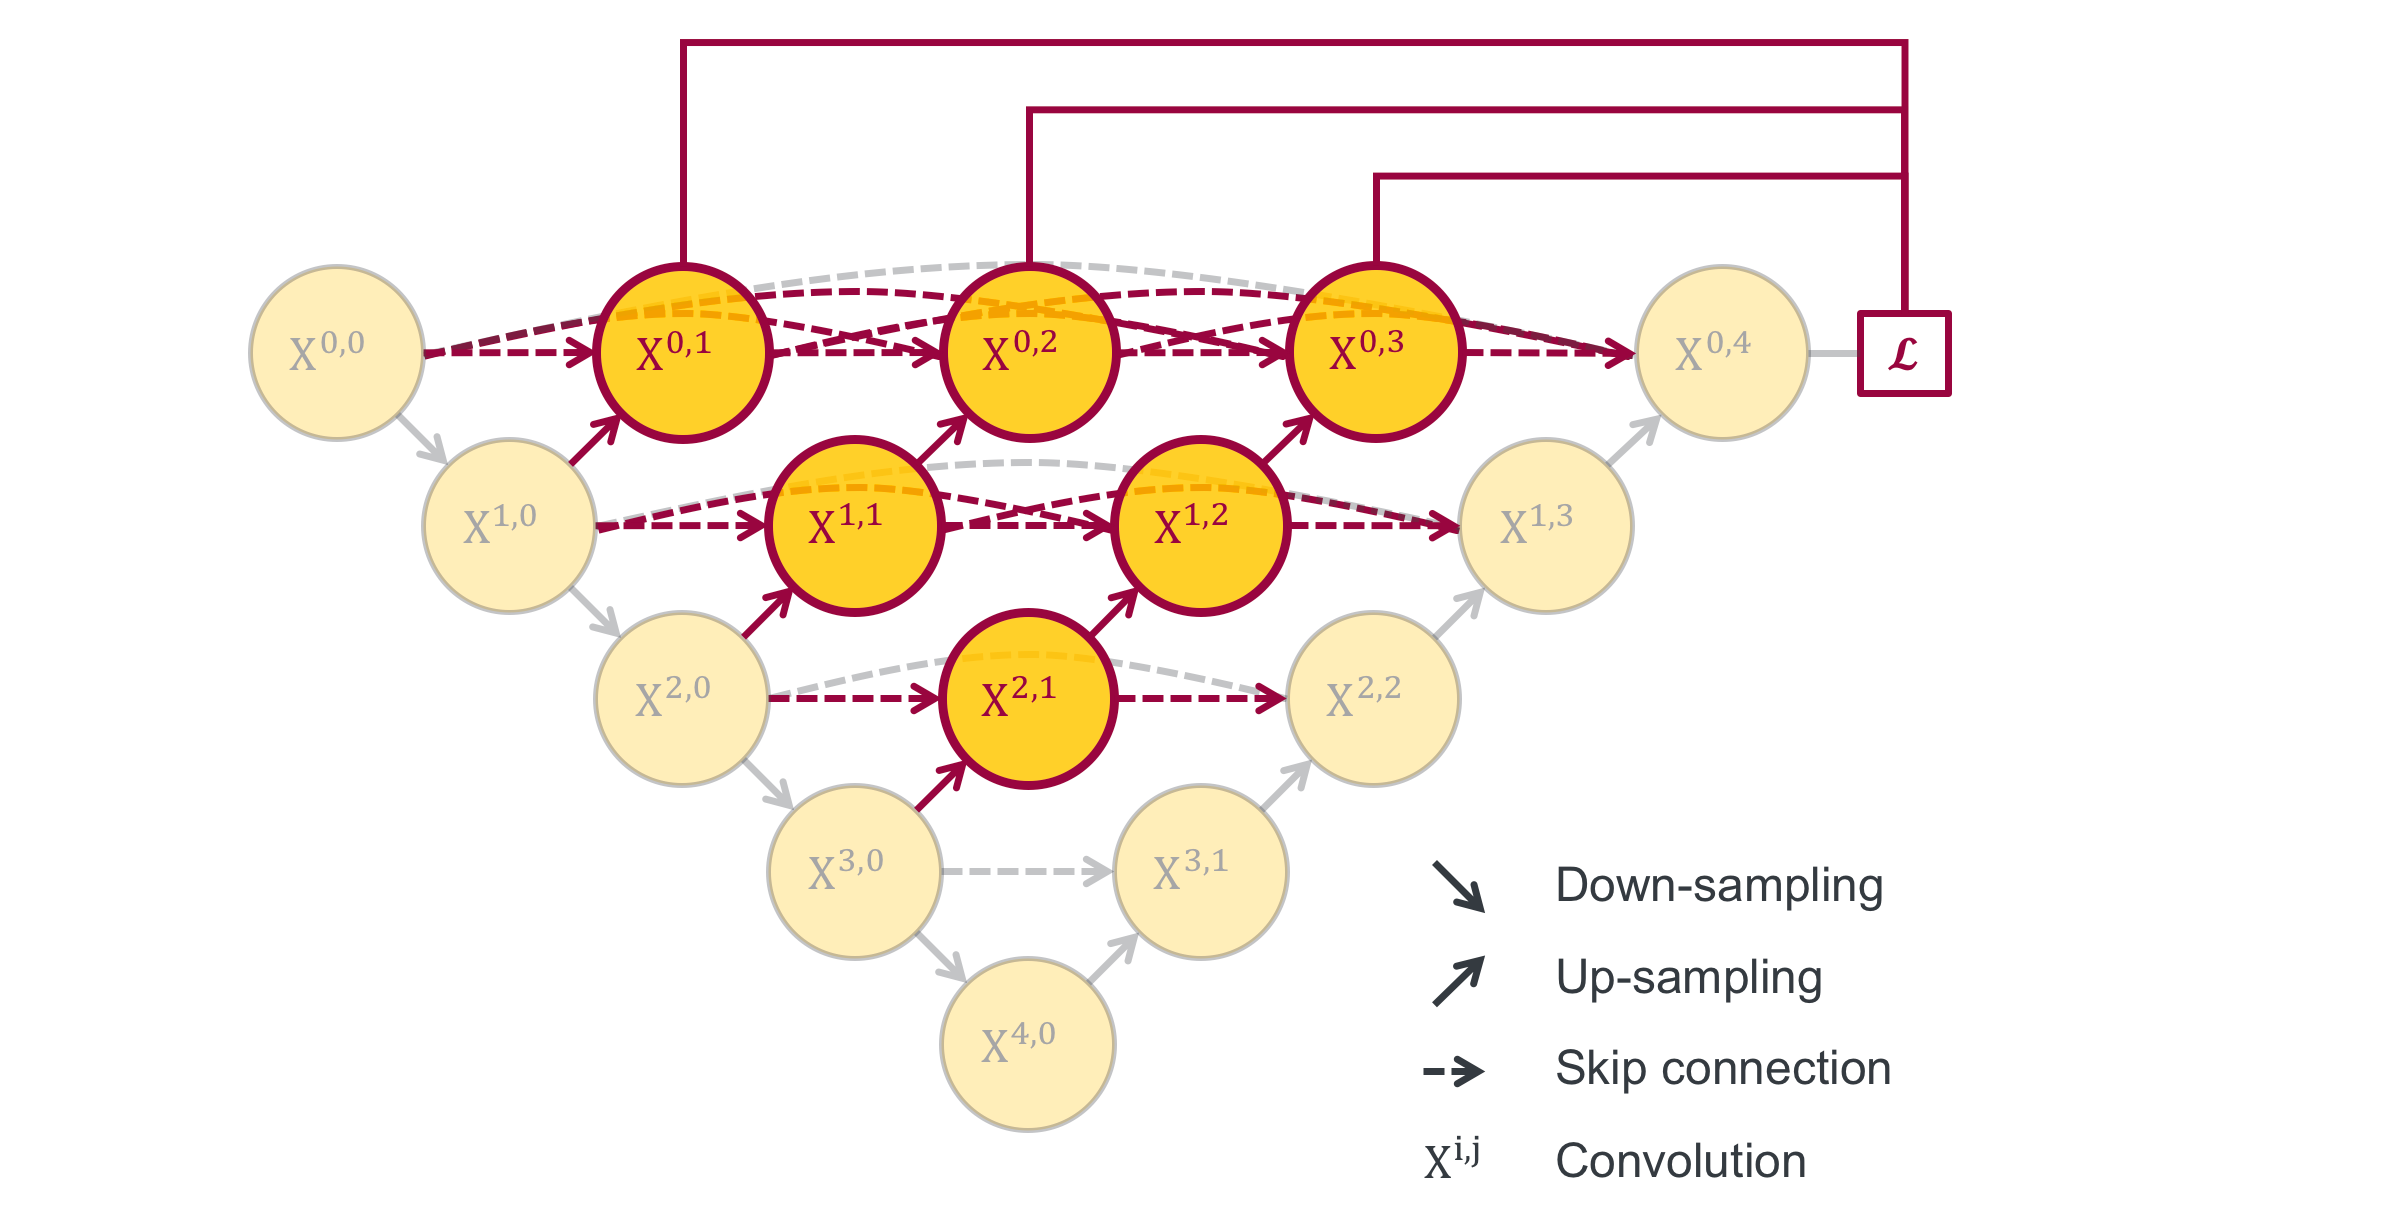

In this kernel I implement Unet Plus Plus with EfficientNet Encoder. Unet Plus Plus introduce intermediate layers to skip connections of U-Net, which naturally form multiple new up-sampling paths from different depths, ensembling U-Nets of various receptive fields. This results in far better performance than traditional Unet. 
For more details please [refer] .( "UNet++: A Nested U-Net Architecture for Medical Image Segmentation" )

- I have made some changes to the augmentation part. 
- I have added TTA.


# Loading Libraries

In [ ]:
#!pip install -U segmentation-models

In [1]:
#!pip install albumentations > /dev/null
#!pip install -U efficientnet==0.0.4
import numpy as np
import pandas as pd
import gc
import keras

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
#import seaborn as sns
#sns.set_style("white")

from sklearn.model_selection import train_test_split,StratifiedKFold

from skimage.transform import resize
import tensorflow as tf
import keras.backend as K
from keras.losses import binary_crossentropy

from keras.preprocessing.image import load_img
from keras import Model
from keras.callbacks import  ModelCheckpoint
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout,BatchNormalization
from keras.layers import Conv2D, Concatenate, MaxPooling2D
from keras.layers import UpSampling2D, Dropout, BatchNormalization
#from tqdm import tqdm_notebook
from keras import initializers
from keras import regularizers
from keras import constraints
from keras.utils import conv_utils
from keras.utils.data_utils import get_file
from keras.engine.topology import get_source_inputs
from keras.engine import InputSpec
from keras import backend as K
from keras.layers import LeakyReLU
from keras.layers import ZeroPadding2D
from keras.losses import binary_crossentropy
import keras.callbacks as callbacks
from keras.callbacks import Callback
from keras.applications.xception import Xception
from keras.layers import multiply


from keras import optimizers
from keras.legacy import interfaces
from keras.utils.generic_utils import get_custom_objects

from keras.engine.topology import Input
from keras.engine.training import Model
from keras.layers.convolutional import Conv2D, UpSampling2D, Conv2DTranspose
from keras.layers.core import Activation, SpatialDropout2D
from keras.layers.merge import concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add
from keras.regularizers import l2
from keras.layers.core import Dense, Lambda
from keras.layers.merge import concatenate, add
from keras.layers import GlobalAveragePooling2D, Reshape, Dense, multiply, Permute
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

import glob
import shutil
import os
import random
from PIL import Image

seed = 10
np.random.seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.set_random_seed(seed)
    
%matplotlib inline

Using TensorFlow backend.


In [2]:
import tensorflow as tf
tf.__version__

tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)

True

In [3]:
print(tf.__version__)

1.15.0


In [4]:
import numpy as np
import tensorflow as tf
import math
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb
import random

import keras
from keras.layers import LeakyReLU
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, add
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.models import Model, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint,LearningRateScheduler,CSVLogger
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
#import segmentation_models as sm
from albumentations import*
import cv2
from random import shuffle                            #
import os
import matplotlib.pyplot as plt
from skimage.io import imsave


import time                                           # measuring training and test time
from glob import glob                                 # path control
#import tqdm
from scipy.ndimage.morphology import binary_fill_holes
from skimage.morphology import remove_small_objects
from scipy.ndimage.filters import gaussian_filter
import skimage.morphology
from skimage import io, exposure, img_as_uint, img_as_float
from skimage.io import imsave, imread
from skimage.transform import resize
from skimage.morphology import label
from skimage.morphology import watershed
from skimage.feature import peak_local_max
#import segmentation_models as sm
from scipy import ndimage as ndi

In [5]:
opts = {}
#opts['tf_version'] = 1.14                      # current version also works with tf 2.2
opts['imageType_train'] = '.tif'
opts['imageType_test'] = '.tif'
opts['number_of_channel'] = 3                   # Set if to '3' for RGB images and set it to '1' for grayscale images
opts['treshold'] = 0.5                          # treshold to convert the network output (stage 1) to binary masks
## input & output directories
opts['train_dir'] = 'dataset/tissue images/'
opts['train_label_dir'] = 'dataset/Annotator 1 (biologist)/mask binary/'
opts['train_label_masks'] = 'dataset/Annotator 1 (biologist)/label masks modify/'
opts['train_dis_dir'] = 'dataset/Annotator 1 (biologist)/distance maps/'
opts['results_save_path'] ='dataset/kaggle/working/images/'
opts['models_save_path'] ='dataset/kaggle/working/models/'

opts['epoch_num_stage1'] = 20                   # number of epochs for stage 1
opts['quick_run'] = 0.01                         # step = (len(train)/batch_size) / quick_run (set it to large numbers just debugging the code)
opts['batch_size'] = 2                         # batch size
opts['random_seed_num'] = 19                    # keep it constant to be able to reproduce the results
opts['k_fold'] = 10                             # set to '1' to have no cross validation (much faster training but 2-3% degradation in performance)
opts['save_val_results'] = 1                    # set to '0' to skip saving the validation results in training
opts['init_LR'] = 0.001                         # initial learning rate for stage 1 and stage 2
opts['LR_decay_factor'] = 0.5                   # learning rate scheduler
opts['LR_drop_after_nth_epoch'] = 8            # learning rate scheduler
opts['crop_size'] = 512                         # crop size for training
opts['pretrained_model'] = 'efficientnetb0'     # future development 
opts['use_pretrained_flag'] = 0                 # if you want to use a pretrained model in the encoder set it to one



In [6]:
# Dice loss function
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)
#####################################################################################
# Combination of Dice and binary cross entophy loss function
def bce_dice_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)
########################################################################################
# custom callsback (decaying learning rate)
def step_decay_schedule(initial_lr=1e-3, decay_factor=0.75, epochs_drop=1000):
    '''
    Wrapper function to create a LearningRateScheduler with step decay schedule.
    '''
    def schedule(epoch):
        return initial_lr * (decay_factor ** np.floor(epoch/epochs_drop))
    
    return LearningRateScheduler(schedule, verbose = 1)
#######################################################################################################

In [7]:
## disabeling warning msg
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# 0 = all messages are logged (default behavior)
# 1 = INFO messages are not printed
# 2 = INFO and WARNING messages are not printed
# 3 = INFO, WARNING, and ERROR messages are not printed
import warnings
warnings.simplefilter('ignore')
import sys
sys.stdout.flush() # resolving tqdm problem

In [8]:
def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    if activation == True:
        x = LeakyReLU(alpha=0.1)(x)
    return x

def residual_block(blockInput, num_filters=16):
    x = LeakyReLU(alpha=0.1)(blockInput)
    x = BatchNormalization()(x)
    blockInput = BatchNormalization()(blockInput)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    return x

In [9]:
from efficientnet import EfficientNetB4

def UEfficientNet(input_shape=(None, None, 3),dropout_rate=0.1):

    backbone = EfficientNetB4(weights='imagenet',
                            include_top=False,
                            input_shape=input_shape)
    input = backbone.input
    start_neurons = 8

    conv4 = backbone.layers[342].output
    conv4 = LeakyReLU(alpha=0.1)(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(dropout_rate)(pool4)
    
     # Middle
    convm = Conv2D(start_neurons * 32, (3, 3), activation=None, padding="same",name='conv_middle')(pool4)
    convm = residual_block(convm,start_neurons * 32)
    convm = residual_block(convm,start_neurons * 32)
    convm = LeakyReLU(alpha=0.1)(convm)
    
    deconv4 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(convm)
    deconv4_up1 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(deconv4)
    deconv4_up2 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(deconv4_up1)
    deconv4_up3 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(deconv4_up2)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(dropout_rate)(uconv4) 
    
    uconv4 = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 16)
#     uconv4 = residual_block(uconv4,start_neurons * 16)
    uconv4 = LeakyReLU(alpha=0.1)(uconv4)  #conv1_2
    
    deconv3 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(uconv4)
    deconv3_up1 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(deconv3)
    deconv3_up2 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(deconv3_up1)
    conv3 = backbone.layers[154].output
    uconv3 = concatenate([deconv3,deconv4_up1, conv3])    
    uconv3 = Dropout(dropout_rate)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 8)
#     uconv3 = residual_block(uconv3,start_neurons * 8)
    uconv3 = LeakyReLU(alpha=0.1)(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv3)
    deconv2_up1 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(deconv2)
    conv2 = backbone.layers[92].output
    uconv2 = concatenate([deconv2,deconv3_up1,deconv4_up2, conv2])
        
    uconv2 = Dropout(0.1)(uconv2)
    uconv2 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 4)
#     uconv2 = residual_block(uconv2,start_neurons * 4)
    uconv2 = LeakyReLU(alpha=0.1)(uconv2)
    
    deconv1 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv2)
    conv1 = backbone.layers[30].output
    uconv1 = concatenate([deconv1,deconv2_up1,deconv3_up2,deconv4_up3, conv1])
    
    uconv1 = Dropout(0.1)(uconv1)
    uconv1 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 2)
#     uconv1 = residual_block(uconv1,start_neurons * 2)
    uconv1 = LeakyReLU(alpha=0.1)(uconv1)
    
    uconv0 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv1)   
    uconv0 = Dropout(0.1)(uconv0)
    uconv0 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv0)
    uconv0 = residual_block(uconv0,start_neurons * 1)
#     uconv0 = residual_block(uconv0,start_neurons * 1)
    uconv0 = LeakyReLU(alpha=0.1)(uconv0)
    
    uconv0 = Dropout(dropout_rate/2)(uconv0)
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv0)    
    
    model = Model(input, output_layer)
    model.name = 'u-xception'

    return model

In [10]:
model = UEfficientNet(input_shape=(512,512,3),dropout_rate=0.5) 
model.compile(optimizer = Adam(lr=0.001), loss= bce_dice_loss , metrics=[dice_coef])


Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
model.summary()

In [11]:
# augmentation function
def albumentation_aug(p=1.0, crop_size_row = 448, crop_size_col = 448 ):
    return Compose([
        RandomCrop(crop_size_row, crop_size_col, always_apply=True, p=1),
        CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5),
        RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0.15,  p=0.4),#brightness_by_max=True,
        HueSaturationValue(hue_shift_limit=20, sat_shift_limit=20, val_shift_limit=20, p=0.1),
        HorizontalFlip(always_apply=False, p=0.5),
        VerticalFlip(always_apply=False, p=0.5),
        RandomRotate90(always_apply=False, p=0.5),
        #ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=20, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.3),
    ], p=p) # --> this p has the second proiroty comapred to the p inside each argument (e.g. HorizontalFlip(always_apply=False, p=0.5) )
###########################################################
def albumentation_aug_light(p=1.0, crop_size_row = 448, crop_size_col = 448):
    return Compose([
        RandomCrop(crop_size_row, crop_size_col, always_apply=True, p=1.0),
        HorizontalFlip(always_apply=False, p=0.5),
        VerticalFlip(always_apply=False, p=0.5),
        RandomRotate90(always_apply=False, p=0.5),
        ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=20, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.1),
    ], p=p, additional_targets={'mask1': 'mask','mask2': 'mask'}) # --> this p has the second proiroty comapred to the p inside each argument (e.g. HorizontalFlip(always_apply=False, p=0.5) )


In [12]:
def get_dice_1(true, pred):
    """
        Traditional dice
    """
    # cast to binary 1st
    true = np.copy(true)
    pred = np.copy(pred)
    true[true > 0] = 1
    pred[pred > 0] = 1
    inter = true * pred
    denom = true + pred
    return 2.0 * np.sum(inter) / np.sum(denom)
##############################################################################################
def get_fast_aji(true, pred):
    """
    AJI version distributed by MoNuSeg, has no permutation problem but suffered from 
    over-penalisation similar to DICE2
    Fast computation requires instance IDs are in contiguous orderding i.e [1, 2, 3, 4] 
    not [2, 3, 6, 10]. Please call `remap_label` before hand and `by_size` flag has no 
    effect on the result.
    """
    true = np.copy(true) # ? do we need this
    pred = np.copy(pred)
    true_id_list = list(np.unique(true))
    pred_id_list = list(np.unique(pred))

    true_masks = [None,]
    for t in true_id_list[1:]:
        t_mask = np.array(true == t, np.uint8)
        true_masks.append(t_mask)
    
    pred_masks = [None,]
    for p in pred_id_list[1:]:
        p_mask = np.array(pred == p, np.uint8)
        pred_masks.append(p_mask)
    
    # prefill with value
    pairwise_inter = np.zeros([len(true_id_list) -1, 
                               len(pred_id_list) -1], dtype=np.float64)
    pairwise_union = np.zeros([len(true_id_list) -1, 
                               len(pred_id_list) -1], dtype=np.float64)

    # caching pairwise
    for true_id in true_id_list[1:]: # 0-th is background
       # print(true_id)
        t_mask = true_masks[true_id]
        pred_true_overlap = pred[t_mask > 0]
        pred_true_overlap_id = np.unique(pred_true_overlap)
        pred_true_overlap_id = list(pred_true_overlap_id)
        for pred_id in pred_true_overlap_id:
            if pred_id == 0: # ignore
                continue # overlaping background
            p_mask = pred_masks[pred_id]
            total = (t_mask + p_mask).sum()
            inter = (t_mask * p_mask).sum()
            pairwise_inter[true_id-1, pred_id-1] = inter
            pairwise_union[true_id-1, pred_id-1] = total - inter
    #
    pairwise_iou = pairwise_inter / (pairwise_union + 1.0e-6)
    # pair of pred that give highest iou for each true, dont care 
    # about reusing pred instance multiple times
    paired_pred = np.argmax(pairwise_iou, axis=1)
    pairwise_iou = np.max(pairwise_iou, axis=1)
    # exlude those dont have intersection
    paired_true = np.nonzero(pairwise_iou > 0.0)[0]
    paired_pred = paired_pred[paired_true]
    # print(paired_true.shape, paired_pred.shape)
    overall_inter = (pairwise_inter[paired_true, paired_pred]).sum()
    overall_union = (pairwise_union[paired_true, paired_pred]).sum()
    #
    paired_true = (list(paired_true + 1)) # index to instance ID
    paired_pred = (list(paired_pred + 1))
    # add all unpaired GT and Prediction into the union
    unpaired_true = np.array([idx for idx in true_id_list[1:] if idx not in paired_true])
    unpaired_pred = np.array([idx for idx in pred_id_list[1:] if idx not in paired_pred])
    for true_id in unpaired_true:
        overall_union += true_masks[true_id].sum()
    for pred_id in unpaired_pred:
        overall_union += pred_masks[pred_id].sum()
    #
    aji_score = overall_inter / overall_union
    return aji_score
##############################################################################################
def remap_label(pred, by_size=False):
    """
    Rename all instance id so that the id is contiguous i.e [0, 1, 2, 3] 
    not [0, 2, 4, 6]. The ordering of instances (which one comes first) 
    is preserved unless by_size=True, then the instances will be reordered
    so that bigger nucler has smaller ID
    Args:
        pred    : the 2d array contain instances where each instances is marked
                  by non-zero integer
        by_size : renaming with larger nuclei has smaller id (on-top)
    """
    pred_id = list(np.unique(pred))
    pred_id.remove(0)
    if len(pred_id) == 0:
        return pred # no label
    if by_size:
        pred_size = []
        for inst_id in pred_id:
            size = (pred == inst_id).sum()
            pred_size.append(size)
        # sort the id by size in descending order
        pair_list = zip(pred_id, pred_size)
        pair_list = sorted(pair_list, key=lambda x: x[1], reverse=True)
        pred_id, pred_size = zip(*pair_list)

    new_pred = np.zeros(pred.shape, np.int32)
    for idx, inst_id in enumerate(pred_id):
        new_pred[pred == inst_id] = idx + 1    
    return new_pred

##############################################################################################
def get_fast_pq(true, pred, match_iou=0.5):
    """
    `match_iou` is the IoU threshold level to determine the pairing between
    GT instances `p` and prediction instances `g`. `p` and `g` is a pair
    if IoU > `match_iou`. However, pair of `p` and `g` must be unique
    (1 prediction instance to 1 GT instance mapping).
    If `match_iou` < 0.5, Munkres assignment (solving minimum weight matching
    in bipartite graphs) is caculated to find the maximal amount of unique pairing.
    If `match_iou` >= 0.5, all IoU(p,g) > 0.5 pairing is proven to be unique and
    the number of pairs is also maximal.
    Fast computation requires instance IDs are in contiguous orderding
    i.e [1, 2, 3, 4] not [2, 3, 6, 10]. Please call `remap_label` beforehand
    and `by_size` flag has no effect on the result.
    Returns:
        [dq, sq, pq]: measurement statistic
        [paired_true, paired_pred, unpaired_true, unpaired_pred]:
                      pairing information to perform measurement
    """
    assert match_iou >= 0.0, "Cant' be negative"

    true = np.copy(true)
    pred = np.copy(pred)
    true_id_list = list(np.unique(true))
    pred_id_list = list(np.unique(pred))

    true_masks = [None, ]
    for t in true_id_list[1:]:
        t_mask = np.array(true == t, np.uint8)
        true_masks.append(t_mask)

    pred_masks = [None, ]
    for p in pred_id_list[1:]:
        p_mask = np.array(pred == p, np.uint8)
        pred_masks.append(p_mask)

    # prefill with value
    pairwise_iou = np.zeros([len(true_id_list) - 1,
                             len(pred_id_list) - 1], dtype=np.float64)

    # caching pairwise iou
    for true_id in true_id_list[1:]:  # 0-th is background
        t_mask = true_masks[true_id]
        pred_true_overlap = pred[t_mask > 0]
        pred_true_overlap_id = np.unique(pred_true_overlap)
        pred_true_overlap_id = list(pred_true_overlap_id)
        for pred_id in pred_true_overlap_id:
            if pred_id == 0:  # ignore
                continue  # overlaping background
            p_mask = pred_masks[pred_id]
            total = (t_mask + p_mask).sum()
            inter = (t_mask * p_mask).sum()
            iou = inter / (total - inter)
            pairwise_iou[true_id - 1, pred_id - 1] = iou
    #
    if match_iou >= 0.5:
        paired_iou = pairwise_iou[pairwise_iou > match_iou]
        pairwise_iou[pairwise_iou <= match_iou] = 0.0
        paired_true, paired_pred = np.nonzero(pairwise_iou)
        paired_iou = pairwise_iou[paired_true, paired_pred]
        paired_true += 1  # index is instance id - 1
        paired_pred += 1  # hence return back to original
    else:  # * Exhaustive maximal unique pairing
        #### Munkres pairing with scipy library
        # the algorithm return (row indices, matched column indices)
        # if there is multiple same cost in a row, index of first occurence
        # is return, thus the unique pairing is ensure
        # inverse pair to get high IoU as minimum
        paired_true, paired_pred = linear_sum_assignment(-pairwise_iou)
        ### extract the paired cost and remove invalid pair
        paired_iou = pairwise_iou[paired_true, paired_pred]

        # now select those above threshold level
        # paired with iou = 0.0 i.e no intersection => FP or FN
        paired_true = list(paired_true[paired_iou > match_iou] + 1)
        paired_pred = list(paired_pred[paired_iou > match_iou] + 1)
        paired_iou = paired_iou[paired_iou > match_iou]

    # get the actual FP and FN
    unpaired_true = [idx for idx in true_id_list[1:] if idx not in paired_true]
    unpaired_pred = [idx for idx in pred_id_list[1:] if idx not in paired_pred]
    # print(paired_iou.shape, paired_true.shape, len(unpaired_true), len(unpaired_pred))

    #
    tp = len(paired_true)
    fp = len(unpaired_pred)
    fn = len(unpaired_true)
    # get the F1-score i.e DQ
    dq = tp / (tp + 0.5 * fp + 0.5 * fn)
    # get the SQ, no paired has 0 iou so not impact
    sq = paired_iou.sum() / (tp + 1.0e-6)

    return [dq, sq, dq * sq], [paired_true, paired_pred, unpaired_true, unpaired_pred]

In [13]:
# other useful finction for training

def get_id_from_file_path(file_path, indicator):
    return file_path.split(os.path.sep)[-1].replace(indicator, '')
############################################################
def chunker(seq, seq2, size):
    return ([seq[pos:pos + size], seq2[pos:pos + size]] for pos in range(0, len(seq), size))
############################################################
def data_gen_heavy(list_files, list_files2, batch_size, p , size_row, size_col, distance_unet_flag = 0, augment=False, BACKBONE_model = 'efficientnetb0', use_pretrain_flag =1):
    #preprocess_input = sm.get_preprocessing(BACKBONE_model)
    crop_size_row = size_row
    crop_size_col = size_col
    aug = albumentation_aug(p, crop_size_row, crop_size_col)

    while True:
        #shuffle(list_files)
        for batch in chunker(list_files,list_files2, batch_size):
            #X = [cv2.resize(cv2.imread(x), (size, size)) for x in batch]
            X = []
            Y = []

            for count in range(len(batch[0])):
                # x = cv2.resize(cv2.imread(batch[0][count]), (size_col, size_row))
                # x_mask = cv2.resize(cv2.imread(batch[1][count], cv2.IMREAD_GRAYSCALE), (size_col, size_row))
                x = cv2.imread(batch[0][count])
                x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
                x_mask = cv2.imread(batch[1][count], cv2.IMREAD_GRAYSCALE)
                
                x_mask_temp = np.zeros((x_mask.shape[0], x_mask.shape[1]))
                x_mask_temp[x_mask == 255] = 1
                

                if distance_unet_flag == False:
                    if augment:
                        augmented = aug(image= x, mask= x_mask_temp)
                        x = augmented['image']
                        if use_pretrain_flag == 1:
                            x = preprocess_input(x)
                        x_mask_temp = augmented['mask']
                        x = x/255
                    X.append(x)
                    Y.append(x_mask_temp)
                    #imsave('/media/masih/wd/projects/MoNuSAC_binary/results/images/an/{}_binary.png'.format(get_id_from_file_path(batch[0][count], '.png')), x_mask_epithelial)
                    #imsave('/media/masih/wd/projects/MoNuSAC_binary/results/images/an/{}.png'.format(get_id_from_file_path(batch[0][count], '.tif')), x)
                else:
                    if augment:
                        augmented = aug(image=x, mask=x_mask)
                        x = augmented['image']
                        if use_pretrain_flag == 1:
                            x = preprocess_input(x)
                        x_mask = augmented['mask']

                    X.append(x)
                    x_mask = (x_mask - np.min(x_mask))/ (np.max(x_mask) - np.min(x_mask) + 0.0000001)
                    Y.append(x_mask)

                del x_mask
                del x_mask_temp
                del x
            Y = np.expand_dims(np.array(Y), axis=3)
            Y = np.array(Y)
            yield np.array(X), np.array(Y)

In [15]:
# create folders to save the best models and images (if needed) for each fold
if not os.path.exists('datset/kaggle/working/images/'):
    os.makedirs('dataset/kaggle/working/images/')
if not os.path.exists('dataset/kaggle/working/models/'):
    os.makedirs('dataset/kaggle/working/models/')    
if not os.path.exists(opts['results_save_path']+ 'stage1/validation/pure_unet'):
    os.makedirs(opts['results_save_path'] + 'stage1/validation/pure_unet')
if not os.path.exists(opts['results_save_path']+ 'stage1/validation/watershed_unet'):
    os.makedirs(opts['results_save_path'] + 'stage1/validation/watershed_unet')    


In [16]:
train_files = glob('{}*{}'.format(opts['train_dir'], opts['imageType_train']))
train_files_mask = glob('{}*.png'.format(opts['train_label_dir']))
train_files_dis = glob('{}*.png'.format(opts['train_dis_dir']))
train_files_labels = glob('{}*.tif'.format(opts['train_label_masks']))


train_files.sort()
train_files_mask.sort()
train_files_dis.sort()
train_files_labels.sort()
print("Total number of training images:", len(train_files))

Total number of training images: 30


In [17]:
# we have 10 organ in this dataset
train_files

['dataset/tissue images\\Human_AdrenalGland_01.tif',
 'dataset/tissue images\\Human_AdrenalGland_02.tif',
 'dataset/tissue images\\Human_AdrenalGland_03.tif',
 'dataset/tissue images\\Human_Larynx_01.tif',
 'dataset/tissue images\\Human_Larynx_02.tif',
 'dataset/tissue images\\Human_Larynx_03.tif',
 'dataset/tissue images\\Human_LymphNodes_01.tif',
 'dataset/tissue images\\Human_LymphNodes_02.tif',
 'dataset/tissue images\\Human_LymphNodes_03.tif',
 'dataset/tissue images\\Human_Mediastinum_01.tif',
 'dataset/tissue images\\Human_Mediastinum_02.tif',
 'dataset/tissue images\\Human_Mediastinum_03.tif',
 'dataset/tissue images\\Human_Pancreas_01.tif',
 'dataset/tissue images\\Human_Pancreas_02.tif',
 'dataset/tissue images\\Human_Pancreas_03.tif',
 'dataset/tissue images\\Human_Pleura_01.tif',
 'dataset/tissue images\\Human_Pleura_02.tif',
 'dataset/tissue images\\Human_Pleura_03.tif',
 'dataset/tissue images\\Human_Skin_01.tif',
 'dataset/tissue images\\Human_Skin_02.tif',
 'dataset/tis

In [18]:
# creating 10 folds to perfrom 10 fold cross-validation (for each fold images from the 9 organs are used for training and the images from one organ are used as validation)

for k in range(opts['k_fold']):
    if k ==0:
        fold1 = train_files[0: int(np.round(len(train_files) / opts['k_fold']))]
    else:
        globals()["fold" + str(k + 1)] = train_files[int(np.round(len (train_files) / opts['k_fold']) * k): int(np.round(len(train_files) / opts['k_fold']) * (k+1))]
print("length of each fold:", len(fold1))

# for binary mask
for k in range(opts['k_fold']):
    if k ==0:
        fold_mask1 = train_files_mask[0: int(np.round(len(train_files_mask) / opts['k_fold']))]
    else:
        globals()["fold_mask" + str(k + 1)] = train_files_mask[int(np.round(len (train_files_mask) / opts['k_fold']) * k): int(np.round(len(train_files_mask) / opts['k_fold']) * (k+1))]

# for distance mask
for k in range(opts['k_fold']):
    if k ==0:
        fold_dis1 = train_files_dis[0: int(np.round(len(train_files_dis) / opts['k_fold']))]
    else:
        globals()["fold_dis" + str(k + 1)] = train_files_dis[int(np.round(len (train_files_dis) / opts['k_fold']) * k): int(np.round(len(train_files_dis) / opts['k_fold']) * (k+1))]

# for label masks (just for evaluation)
for k in range(opts['k_fold']):
    if k ==0:
        fold_label1 = train_files_labels[0: int(np.round(len(train_files_labels) / opts['k_fold']))]
    else:
        globals()["fold_label" + str(k + 1)] = train_files_labels[int(np.round(len (train_files_labels) / opts['k_fold']) * k): int(np.round(len(train_files_labels) / opts['k_fold']) * (k+1))]


length of each fold: 3


In [19]:
# main training loop (for all 10 fold cross-validation)
start_time = time.time()
dice_pure_unet = np.zeros([opts['k_fold'],len(fold1)])
AJI_pure_unet = np.zeros([opts['k_fold'],len(fold1)])
PQ_pure_unet = np.zeros([opts['k_fold'],len(fold1)])

dice_unet_watershed = np.zeros([opts['k_fold'],len(fold1)])
AJI_unet_watershed = np.zeros([opts['k_fold'],len(fold1)])
PQ_unet_watershed = np.zeros([opts['k_fold'],len(fold1)])



for K_fold in range(opts['k_fold']):    
    train = []
    train_mask = []
    train_dis = []
    
    val = eval('fold' + str(K_fold + 1))
    val_mask = eval('fold_mask' + str(K_fold + 1))
    val_dis = eval('fold_dis' + str(K_fold + 1))
    val_label = eval('fold_label' + str(K_fold + 1))

    for ii in range(opts['k_fold']):
        if ii != K_fold:
            train = eval('fold' + str(ii + 1)) + train

    for ii in range(opts['k_fold']):
        if ii != K_fold:
            train_mask = eval('fold_mask' + str(ii + 1)) + train_mask

    for ii in range(opts['k_fold']):
        if ii != K_fold:
            train_dis = eval('fold_dis' + str(ii + 1)) + train_dis

    if opts['k_fold'] == 1: # for no cross validation the training will be with all training images
        train = train_files
        train_mask = train_files_mask
        train_dis = train_files_dis
   
    random.Random(opts['random_seed_num']).shuffle(train)
    random.Random(opts['random_seed_num']).shuffle(train_mask)
    random.Random(opts['random_seed_num']).shuffle(train_dis)
 

    ## creating validation data for each fold (just for evaluation)
    # it is not included in the main training loop for a faster training
    validation_X = []
    validation_Y = []
    validation_DIS = []
    if len(val)<200: # memory consideration
        for an in range(len(val)):
            x = cv2.imread(val[an])
            x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
            #x = cv2.resize(x,(128, 128), 3)
            #aug = albumentation_aug_light(1, opts['crop_size'], opts['crop_size'])
            #augmented = aug(image=x)
            #x = augmented['image']
            if opts['use_pretrained_flag'] == 1:
                x = preprocess_input(x)
            img_mask = imread(val_label[an])
            #img_mask = resize(img_mask,(128,128), anti_aliasing=True)
            x = x/255
            validation_X.append(x)
            validation_Y.append(img_mask)

    else:
        for an in range(200):
            x = cv2.imread(val[an])
            x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
            #x = cv2.resize(x,(128, 128), 3)

            #aug = albumentation_aug_light(1, opts['crop_size'], opts['crop_size'])
            #augmented = aug(image=x)
            #x = augmented['image']
            if opts['use_pretrained_flag'] ==1:
                x = preprocess_input(x)
            img_mask = imread(val_label[an])
            #img_mask = resize(img_mask,(128,128), anti_aliasing=True)
            x = x/255
            validation_X.append(x)
            validation_Y.append(img_mask)

    validation_X = np.array(validation_X)
    validation_Y = np.array(validation_Y)
    
    
    model_path = opts['models_save_path'] + 'raw_unet_{}.h5'.format(K_fold+1)
    logger = CSVLogger(opts['models_save_path']+ 'raw_unet_{}.log'.format(K_fold + 1))
    LR_drop = step_decay_schedule(initial_lr= opts['init_LR'], decay_factor = opts['LR_decay_factor'], epochs_drop = opts['LR_drop_after_nth_epoch'])
    #model_raw = deeper_binary_unet(opts['number_of_channel'], opts['init_LR'])
    model_raw = model
    checkpoint = ModelCheckpoint(model_path, monitor='val_dice_coef', verbose=1, save_best_only=True, mode='max', save_weights_only = True)
    
    # training
    history = model_raw.fit_generator(data_gen_heavy(train,
                                                     train_mask,
                                                     opts['batch_size'],
                                                     1,
                                                     opts['crop_size'], opts['crop_size'],
                                                     distance_unet_flag=0,
                                                     augment=True,
                                                     BACKBONE_model=opts['pretrained_model'],
                                                     use_pretrain_flag=opts['use_pretrained_flag']),
                                      validation_data=data_gen_heavy(val,
                                                                     val_mask,
                                                                     opts['batch_size'],
                                                                     1,
                                                                     opts['crop_size'], opts['crop_size'],
                                                                     distance_unet_flag=0,
                                                                     augment=True,
                                                                     BACKBONE_model=opts['pretrained_model'],
                                                                     use_pretrain_flag=opts['use_pretrained_flag']),
                                      validation_steps=1,
                                      epochs=opts['epoch_num_stage1'], verbose=1,
                                      callbacks=[checkpoint, logger, LR_drop],
                                      steps_per_epoch=(len(train) // opts['batch_size']) // opts['quick_run'])
    
    model_raw.load_weights(opts['models_save_path'] + 'raw_unet_{}.h5'.format(K_fold + 1))

    ## predication on validation set
    preds_val = model_raw.predict(validation_X, verbose=1, batch_size=1)
    preds_val_t = (preds_val > opts['treshold']).astype(np.uint8)


    for val_len in range(len(preds_val)):
        # with watershed post processing
        local_maxi = peak_local_max(np.squeeze(preds_val[val_len]), indices=False,exclude_border=False, footprint=np.ones((15, 15)))
        markers = ndi.label(local_maxi)[0]
        labels = watershed(-np.squeeze(preds_val[val_len]), markers,mask = np.squeeze(preds_val_t[[val_len]]))
        labels[np.squeeze(preds_val_t[[val_len]])==0] = 0
        
        # without post processing 
        pred = np.squeeze(preds_val_t[val_len])
        label_pred = skimage.morphology.label(pred)
        
        label_pred = remap_label(label_pred)
        validation_Y[val_len] = remap_label(validation_Y[val_len])
        labels = remap_label(labels)
        
        imsave(opts['results_save_path'] + 'stage1/validation/watershed_unet/{}.png'.format(get_id_from_file_path(val[val_len], opts['imageType_train'])),labels.astype(np.uint16))
        imsave(opts['results_save_path'] + 'stage1/validation/pure_unet/{}.png'.format(get_id_from_file_path(val[val_len], opts['imageType_train'])),label_pred.astype(np.uint16))


        
        dice_pure_unet[K_fold, val_len]= get_dice_1(validation_Y[val_len], label_pred)
        AJI_pure_unet[K_fold, val_len] = get_fast_aji(validation_Y[val_len], label_pred,)
        PQ_pure_unet[K_fold, val_len] = get_fast_pq(validation_Y[val_len], label_pred,)[0][2]
        
        dice_unet_watershed[K_fold, val_len]= get_dice_1(validation_Y[val_len],labels, )
        AJI_unet_watershed[K_fold, val_len] = get_fast_aji(validation_Y[val_len], labels)
        PQ_unet_watershed[K_fold, val_len]  = get_fast_pq(validation_Y[val_len], labels)[0][2]
        
        
    print('==========')    
    print('average dice pure Unet for fold{}:'.format(K_fold), np.mean(dice_pure_unet[K_fold, :]))
    print('average AJI pure Unet for fold{}:'.format(K_fold), np.mean(AJI_pure_unet[K_fold, :]))
    print('average PQ pure Unet for fold{}:'.format(K_fold), np.mean(PQ_pure_unet[K_fold, :]))

    print('==========') 
    
    print('==========')    
    print('average Dice Unet watershed for fold{}:'.format(K_fold), np.mean(dice_unet_watershed[K_fold, :]))
    print('average AJI Unet watershed for fold{}:'.format(K_fold), np.mean(AJI_unet_watershed[K_fold, :]))
    print('average PQ Unet watershed for fold{}:'.format(K_fold), np.mean(PQ_unet_watershed[K_fold, :]))
    print('==========') 
finish_time = time.time() 
print('==========') 
print('total training time (all 10 folds):',  (finish_time- start_time)/60, 'minutes')



Epoch 1/20

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
1299/1299 [==============================] - 484s 373ms/step - loss: -0.7192 - dice_coef: 0.8227 - val_loss: -0.7532 - val_dice_coef: 0.8315

Epoch 00001: val_dice_coef improved from -inf to 0.83146, saving model to dataset/kaggle/working/models/raw_unet_1.h5
Epoch 2/20

Epoch 00002: LearningRateScheduler setting learning rate to 0.001.
1299/1299 [==============================] - 452s 348ms/step - loss: -0.8317 - dice_coef: 0.8969 - val_loss: -0.6242 - val_dice_coef: 0.7967

Epoch 00002: val_dice_coef did not improve from 0.83146
Epoch 3/20

Epoch 00003: LearningRateScheduler setting learning rate to 0.001.
1299/1299 [==============================] - 452s 348ms/step - loss: -0.8686 - dice_coef: 0.9202 - val_loss: -0.6728 - val_dice_coef: 0.8087

Epoch 00003: val_dice_coef did not improve from 0.83146
Epoch 4/20

Epoch 00004: LearningRateScheduler setting learning rate to 0.001.
1299/1299 [================

C:\Users\MCSP_Lab\anaconda3\envs\tensorflow 1-15\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\MCSP_Lab\anaconda3\envs\tensorflow 1-15\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\MCSP_Lab\anaconda3\envs\tensorflow 1-15\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


average dice pure Unet for fold0: 0.7756248077349733
average AJI pure Unet for fold0: 0.4752760515947732
average PQ pure Unet for fold0: 0.44722440247934486
average Dice Unet watershed for fold0: 0.7755565199001234
average AJI Unet watershed for fold0: 0.3525702353649012
average PQ Unet watershed for fold0: 0.1902309250059849
Epoch 1/20

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
1299/1299 [==============================] - 453s 348ms/step - loss: -0.8886 - dice_coef: 0.9325 - val_loss: -0.7494 - val_dice_coef: 0.8962

Epoch 00001: val_dice_coef improved from -inf to 0.89622, saving model to dataset/kaggle/working/models/raw_unet_2.h5
Epoch 2/20

Epoch 00002: LearningRateScheduler setting learning rate to 0.001.
1299/1299 [==============================] - 452s 348ms/step - loss: -0.9223 - dice_coef: 0.9526 - val_loss: -0.7091 - val_dice_coef: 0.8726

Epoch 00002: val_dice_coef did not improve from 0.89622
Epoch 3/20

Epoch 00003: LearningRateScheduler setting l

C:\Users\MCSP_Lab\anaconda3\envs\tensorflow 1-15\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\MCSP_Lab\anaconda3\envs\tensorflow 1-15\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\MCSP_Lab\anaconda3\envs\tensorflow 1-15\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


average dice pure Unet for fold1: 0.9095156117490787
average AJI pure Unet for fold1: 0.4528774871646717
average PQ pure Unet for fold1: 0.539360292575114
average Dice Unet watershed for fold1: 0.9085599073288325
average AJI Unet watershed for fold1: 0.4281310971681173
average PQ Unet watershed for fold1: 0.26772327473035745
Epoch 1/20

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
1299/1299 [==============================] - 451s 347ms/step - loss: -0.9041 - dice_coef: 0.9406 - val_loss: -0.6045 - val_dice_coef: 0.8729

Epoch 00001: val_dice_coef improved from -inf to 0.87287, saving model to dataset/kaggle/working/models/raw_unet_3.h5
Epoch 2/20

Epoch 00002: LearningRateScheduler setting learning rate to 0.001.
1299/1299 [==============================] - 449s 346ms/step - loss: -0.9288 - dice_coef: 0.9558 - val_loss: -0.7557 - val_dice_coef: 0.9172

Epoch 00002: val_dice_coef improved from 0.87287 to 0.91723, saving model to dataset/kaggle/working/models/raw_un

C:\Users\MCSP_Lab\anaconda3\envs\tensorflow 1-15\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\MCSP_Lab\anaconda3\envs\tensorflow 1-15\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\MCSP_Lab\anaconda3\envs\tensorflow 1-15\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


average dice pure Unet for fold2: 0.8857307035730068
average AJI pure Unet for fold2: 0.35404401996705825
average PQ pure Unet for fold2: 0.46390577033782815
average Dice Unet watershed for fold2: 0.8825550166169057
average AJI Unet watershed for fold2: 0.4034697255036757
average PQ Unet watershed for fold2: 0.24002046885817185
Epoch 1/20

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
1299/1299 [==============================] - 451s 347ms/step - loss: -0.9167 - dice_coef: 0.9489 - val_loss: -0.8249 - val_dice_coef: 0.9267

Epoch 00001: val_dice_coef improved from -inf to 0.92666, saving model to dataset/kaggle/working/models/raw_unet_4.h5
Epoch 2/20

Epoch 00002: LearningRateScheduler setting learning rate to 0.001.
1299/1299 [==============================] - 451s 347ms/step - loss: -0.9389 - dice_coef: 0.9623 - val_loss: -0.7937 - val_dice_coef: 0.9065

Epoch 00002: val_dice_coef did not improve from 0.92666
Epoch 3/20

Epoch 00003: LearningRateScheduler setting

C:\Users\MCSP_Lab\anaconda3\envs\tensorflow 1-15\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\MCSP_Lab\anaconda3\envs\tensorflow 1-15\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\MCSP_Lab\anaconda3\envs\tensorflow 1-15\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


average dice pure Unet for fold3: 0.9324952851758009
average AJI pure Unet for fold3: 0.34895856767234695
average PQ pure Unet for fold3: 0.4794285926340393
average Dice Unet watershed for fold3: 0.9294200766562924
average AJI Unet watershed for fold3: 0.4665914067952606
average PQ Unet watershed for fold3: 0.33646897386900076
Epoch 1/20

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
1299/1299 [==============================] - 447s 344ms/step - loss: -0.9165 - dice_coef: 0.9507 - val_loss: -0.8274 - val_dice_coef: 0.8864

Epoch 00001: val_dice_coef improved from -inf to 0.88643, saving model to dataset/kaggle/working/models/raw_unet_5.h5
Epoch 2/20

Epoch 00002: LearningRateScheduler setting learning rate to 0.001.
1299/1299 [==============================] - 447s 344ms/step - loss: -0.9371 - dice_coef: 0.9627 - val_loss: -0.8183 - val_dice_coef: 0.8784

Epoch 00002: val_dice_coef did not improve from 0.88643
Epoch 3/20

Epoch 00003: LearningRateScheduler setting 

C:\Users\MCSP_Lab\anaconda3\envs\tensorflow 1-15\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\MCSP_Lab\anaconda3\envs\tensorflow 1-15\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\MCSP_Lab\anaconda3\envs\tensorflow 1-15\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


average dice pure Unet for fold4: 0.8704705347735323
average AJI pure Unet for fold4: 0.44611088267633514
average PQ pure Unet for fold4: 0.40385640580847415
average Dice Unet watershed for fold4: 0.8713098541498807
average AJI Unet watershed for fold4: 0.4280723232302974
average PQ Unet watershed for fold4: 0.24084962524456963
Epoch 1/20

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
1299/1299 [==============================] - 455s 350ms/step - loss: -0.9465 - dice_coef: 0.9683 - val_loss: -0.9019 - val_dice_coef: 0.9344

Epoch 00001: val_dice_coef improved from -inf to 0.93443, saving model to dataset/kaggle/working/models/raw_unet_6.h5
Epoch 2/20

Epoch 00002: LearningRateScheduler setting learning rate to 0.001.
1299/1299 [==============================] - 452s 348ms/step - loss: -0.9569 - dice_coef: 0.9744 - val_loss: -0.9362 - val_dice_coef: 0.9633

Epoch 00002: val_dice_coef improved from 0.93443 to 0.96327, saving model to dataset/kaggle/working/models/raw

C:\Users\MCSP_Lab\anaconda3\envs\tensorflow 1-15\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\MCSP_Lab\anaconda3\envs\tensorflow 1-15\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\MCSP_Lab\anaconda3\envs\tensorflow 1-15\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


average dice pure Unet for fold5: 0.9523994661198855
average AJI pure Unet for fold5: 0.5664855977092468
average PQ pure Unet for fold5: 0.6437484723803135
average Dice Unet watershed for fold5: 0.9516244589183848
average AJI Unet watershed for fold5: 0.49749312300952053
average PQ Unet watershed for fold5: 0.31056495580187293
Epoch 1/20

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
1299/1299 [==============================] - 450s 347ms/step - loss: -0.9489 - dice_coef: 0.9695 - val_loss: -0.9347 - val_dice_coef: 0.9595

Epoch 00001: val_dice_coef improved from -inf to 0.95946, saving model to dataset/kaggle/working/models/raw_unet_7.h5
Epoch 2/20

Epoch 00002: LearningRateScheduler setting learning rate to 0.001.
1299/1299 [==============================] - 450s 347ms/step - loss: -0.9591 - dice_coef: 0.9756 - val_loss: -0.9336 - val_dice_coef: 0.9610

Epoch 00002: val_dice_coef improved from 0.95946 to 0.96104, saving model to dataset/kaggle/working/models/raw_

C:\Users\MCSP_Lab\anaconda3\envs\tensorflow 1-15\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\MCSP_Lab\anaconda3\envs\tensorflow 1-15\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\MCSP_Lab\anaconda3\envs\tensorflow 1-15\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


average dice pure Unet for fold6: 0.9535692384810099
average AJI pure Unet for fold6: 0.5569275811583786
average PQ pure Unet for fold6: 0.6334684767793468
average Dice Unet watershed for fold6: 0.9530996379874089
average AJI Unet watershed for fold6: 0.5758085365219131
average PQ Unet watershed for fold6: 0.3525100570352548
Epoch 1/20

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
1299/1299 [==============================] - 453s 349ms/step - loss: -0.9489 - dice_coef: 0.9692 - val_loss: -0.9455 - val_dice_coef: 0.9707

Epoch 00001: val_dice_coef improved from -inf to 0.97072, saving model to dataset/kaggle/working/models/raw_unet_8.h5
Epoch 2/20

Epoch 00002: LearningRateScheduler setting learning rate to 0.001.
1299/1299 [==============================] - 454s 349ms/step - loss: -0.9612 - dice_coef: 0.9766 - val_loss: -0.9069 - val_dice_coef: 0.9548

Epoch 00002: val_dice_coef did not improve from 0.97072
Epoch 3/20

Epoch 00003: LearningRateScheduler setting le

C:\Users\MCSP_Lab\anaconda3\envs\tensorflow 1-15\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\MCSP_Lab\anaconda3\envs\tensorflow 1-15\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\MCSP_Lab\anaconda3\envs\tensorflow 1-15\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


average dice pure Unet for fold7: 0.9680601099992812
average AJI pure Unet for fold7: 0.43381499000574825
average PQ pure Unet for fold7: 0.5653999538231828
average Dice Unet watershed for fold7: 0.9667534626147076
average AJI Unet watershed for fold7: 0.5455834895565846
average PQ Unet watershed for fold7: 0.3432264193665148
Epoch 1/20

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
1299/1299 [==============================] - 452s 348ms/step - loss: -0.9527 - dice_coef: 0.9710 - val_loss: -0.8271 - val_dice_coef: 0.9384

Epoch 00001: val_dice_coef improved from -inf to 0.93836, saving model to dataset/kaggle/working/models/raw_unet_9.h5
Epoch 2/20

Epoch 00002: LearningRateScheduler setting learning rate to 0.001.
1299/1299 [==============================] - 451s 347ms/step - loss: -0.9642 - dice_coef: 0.9780 - val_loss: -0.9333 - val_dice_coef: 0.9613

Epoch 00002: val_dice_coef improved from 0.93836 to 0.96126, saving model to dataset/kaggle/working/models/raw_u

C:\Users\MCSP_Lab\anaconda3\envs\tensorflow 1-15\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\MCSP_Lab\anaconda3\envs\tensorflow 1-15\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\MCSP_Lab\anaconda3\envs\tensorflow 1-15\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


average dice pure Unet for fold8: 0.9493130323082184
average AJI pure Unet for fold8: 0.4774992550641876
average PQ pure Unet for fold8: 0.5661559287868619
average Dice Unet watershed for fold8: 0.9468596859647217
average AJI Unet watershed for fold8: 0.6010622832064728
average PQ Unet watershed for fold8: 0.414729255645994
Epoch 1/20

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
1299/1299 [==============================] - 452s 348ms/step - loss: -0.9488 - dice_coef: 0.9701 - val_loss: -0.9376 - val_dice_coef: 0.9574

Epoch 00001: val_dice_coef improved from -inf to 0.95745, saving model to dataset/kaggle/working/models/raw_unet_10.h5
Epoch 2/20

Epoch 00002: LearningRateScheduler setting learning rate to 0.001.
1299/1299 [==============================] - 452s 348ms/step - loss: -0.9616 - dice_coef: 0.9772 - val_loss: -0.9613 - val_dice_coef: 0.9763

Epoch 00002: val_dice_coef improved from 0.95745 to 0.97628, saving model to dataset/kaggle/working/models/raw_un

C:\Users\MCSP_Lab\anaconda3\envs\tensorflow 1-15\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\MCSP_Lab\anaconda3\envs\tensorflow 1-15\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\MCSP_Lab\anaconda3\envs\tensorflow 1-15\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


average dice pure Unet for fold9: 0.9735630270942194
average AJI pure Unet for fold9: 0.5794765244266508
average PQ pure Unet for fold9: 0.696047488713409
average Dice Unet watershed for fold9: 0.9731324799898274
average AJI Unet watershed for fold9: 0.6132789673437276
average PQ Unet watershed for fold9: 0.3828873954492254
total training time (all 10 folds): 1525.04161075751 minutes


In [ ]:
a=1
while a==1:
    b=a

In [ ]:
from skimage import img_as_bool

In [ ]:
    validation_X = []
    validation_Y = []
    validation_DIS = []
    if len(val)<200: # memory consideration
        for an in range(len(val)):
            x = cv2.imread(val[an])
            x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
            x = cv2.resize(x,(128, 128), 3)

            #aug = albumentation_aug_light(1, opts['crop_size'], opts['crop_size'])
            #augmented = aug(image=x)
            #x = augmented['image']
            if opts['use_pretrained_flag'] == 1:
                x = preprocess_input(x)
            img_mask = imread(val_label[an])
            #img_mask = img_as_bool(resize(img_mask,(128,128)))
            img_mask = resize(img_mask,(128,128), anti_aliasing=True)
            img_mask = img_mask.astype(np.uint8)
            img_mask = img_mask*1
            print(img_mask.shape)
            print(x.shape)
            x = x/255
            validation_X.append(x)
            validation_Y.append(img_mask)

    else:
        for an in range(200):
            x = cv2.imread(val[an])
            x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
            x = cv2.resize(x,(128, 128), 3)

            #aug = albumentation_aug_light(1, opts['crop_size'], opts['crop_size'])
            #augmented = aug(image=x)
            #x = augmented['image']
            if opts['use_pretrained_flag'] ==1:
                x = preprocess_input(x)
            img_mask = imread(val_label[an])
            #img_mask = img_as_bool(resize(img_mask,(128,128)))
            img_mask = resize(img_mask,(128,128), anti_aliasing=True)#.astype(np.int64)
            img_mask = img_mask.astype(np.uint8)
            #img_mask = img_mask*1
            print(img_mask.shape)
            print(x.shape)
            x = x/255
            validation_X.append(x)
            validation_Y.append(img_mask)

    validation_X = np.array(validation_X)
    validation_Y = np.array(validation_Y)

In [21]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    

In [30]:
print(validation_X[0].shape)
print(validation_Y[0].shape)

(512, 512, 3)
(512, 512)


In [31]:

print(label_pred)
print(validation_Y[val_len])

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


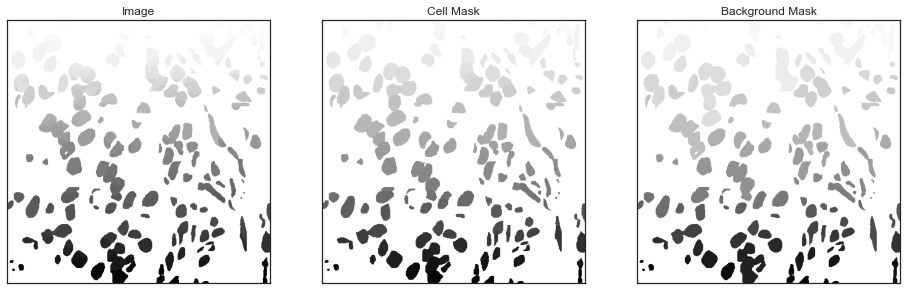

In [22]:
visualize(
    image=labels, 
    cell_mask=validation_Y[val_len],
    background_mask=label_pred,
)

In [ ]:
model_raw.load_weights(opts['models_save_path'] + 'raw_unet_{}.h5'.format(K_fold + 1))

    ## predication on validation set
preds_val = model_raw.predict(validation_X, verbose=1, batch_size=1)
preds_val_t = (preds_val > opts['treshold']).astype(np.uint8)


for val_len in range(len(preds_val)):
        # with watershed post processing
    local_maxi = peak_local_max(np.squeeze(preds_val[val_len]), indices=False,exclude_border=False, footprint=np.ones((15, 15)))
    markers = ndi.label(local_maxi)[0]
    labels = watershed(-np.squeeze(preds_val[val_len]), markers,mask = np.squeeze(preds_val_t[[val_len]]))
    labels[np.squeeze(preds_val_t[[val_len]])==0] = 0
        
        # without post processing 
    pred = np.squeeze(preds_val_t[val_len])
    label_pred = skimage.morphology.label(pred)
        
    label_pred = remap_label(label_pred)
    validation_Y[val_len] = remap_label(validation_Y[val_len])
    labels = remap_label(labels)
        
    imsave(opts['results_save_path'] + 'stage1/validation/watershed_unet/{}.png'.format(get_id_from_file_path(val[val_len], opts['imageType_train'])),labels.astype(np.uint16))
    imsave(opts['results_save_path'] + 'stage1/validation/pure_unet/{}.png'.format(get_id_from_file_path(val[val_len], opts['imageType_train'])),label_pred.astype(np.uint16))


        
    dice_pure_unet[K_fold, val_len]= get_dice_1(validation_Y[val_len], label_pred)
    AJI_pure_unet[K_fold, val_len] = get_fast_aji(validation_Y[val_len], label_pred,)
    PQ_pure_unet[K_fold, val_len] = get_fast_pq(validation_Y[val_len], label_pred,)[0][2]
        
    dice_unet_watershed[K_fold, val_len]= get_dice_1(validation_Y[val_len],labels, )
    AJI_unet_watershed[K_fold, val_len] = get_fast_aji(validation_Y[val_len], labels)
    PQ_unet_watershed[K_fold, val_len]  = get_fast_pq(validation_Y[val_len], labels)[0][2]
        
        
    print('==========')    
    print('average dice pure Unet for fold{}:'.format(K_fold), np.mean(dice_pure_unet[K_fold, :]))
    print('average AJI pure Unet for fold{}:'.format(K_fold), np.mean(AJI_pure_unet[K_fold, :]))
    print('average PQ pure Unet for fold{}:'.format(K_fold), np.mean(PQ_pure_unet[K_fold, :]))

    print('==========') 
    
    print('==========')    
    print('average Dice Unet watershed for fold{}:'.format(K_fold), np.mean(dice_unet_watershed[K_fold, :]))
    print('average AJI Unet watershed for fold{}:'.format(K_fold), np.mean(AJI_unet_watershed[K_fold, :]))
    print('average PQ Unet watershed for fold{}:'.format(K_fold), np.mean(PQ_unet_watershed[K_fold, :]))
    print('==========') 
finish_time = time.time() 
print('==========') 
print('total training time (all 10 folds):',  (finish_time- start_time)/60, 'minutes')

In [ ]:
print(label_pred.shape)
print(validation_Y[val_len].shape)
print(preds_val.shape)

In [ ]:
print(label_pred)

In [23]:
import pandas as pd
organ_name = ['Human_AdrenalGland', 'Human_Larynx', 'Human_LymphNodes', 'Human_Mediastinum', 
              'Human_Pancreas','Human_Pleura', 'Human_Skin', 'Human_Testes' , 'Human_Thymus', 'Human_ThyroidGland']
df = pd.DataFrame({'Oragn': organ_name, 'DICE mean': np.mean(dice_pure_unet, axis = 1), 
                   'AJI mean': np.mean(AJI_pure_unet, axis = 1),
                   'PQ mean': np.mean(PQ_pure_unet, axis = 1)
                  }) 
df.to_csv('final_scores_pure_unet.csv', index=False)
print('averge overall dice score (pure Unet):',"{:.2f}".format(np.mean(dice_pure_unet)*100), '%')
print('averge overall AJI score (pure Unet):', "{:.2f}".format(np.mean(AJI_pure_unet)*100), '%')
print('averge overall PQ score (pure Unet):', "{:.2f}".format(np.mean(PQ_pure_unet)*100), '%')
df

averge overall dice score (pure Unet): 91.71 %
averge overall AJI score (pure Unet): 46.91 %
averge overall PQ score (pure Unet): 54.39 %


,Oragn,DICE mean,AJI mean,PQ mean
0,Human_AdrenalGland,0.775625,0.475276,0.447224
1,Human_Larynx,0.909516,0.452877,0.539360
2,Human_LymphNodes,0.885731,0.354044,0.463906
3,Human_Mediastinum,0.932495,0.348959,0.479429
4,Human_Pancreas,0.870471,0.446111,0.403856
5,Human_Pleura,0.952399,0.566486,0.643748
6,Human_Skin,0.953569,0.556928,0.633468
7,Human_Testes,0.968060,0.433815,0.565400
8,Human_Thymus,0.949313,0.477499,0.566156
9,Human_ThyroidGland,0.973563,0.579477,0.696047


In [24]:
import pandas as pd
organ_name = ['Human_AdrenalGland', 'Human_Larynx', 'Human_LymphNodes', 'Human_Mediastinum', 
              'Human_Pancreas','Human_Pleura', 'Human_Skin', 'Human_Testes' , 'Human_Thymus', 'Human_ThyroidGland']
df = pd.DataFrame({'Oragn': organ_name, 'DICE mean': np.mean(dice_unet_watershed, axis = 1), 
                   'AJI mean': np.mean(AJI_unet_watershed, axis = 1),
                   'PQ mean': np.mean(PQ_unet_watershed, axis = 1),
                  }) 
df.to_csv('final_scores_unet_watershed.csv', index=False)
print('averge overall dice score (Unet + watershed):', "{:.2f}".format(np.mean(dice_unet_watershed)*100),'%')
print('averge overall AJI score (Unet + watershed):', "{:.2f}".format(np.mean(AJI_unet_watershed)*100),'%')
print('averge overall PQ score (Unet + watershed):', "{:.2f}".format(np.mean(PQ_unet_watershed)*100),'%')

df

averge overall dice score (Unet + watershed): 91.59 %
averge overall AJI score (Unet + watershed): 49.12 %
averge overall PQ score (Unet + watershed): 30.79 %


,Oragn,DICE mean,AJI mean,PQ mean
0,Human_AdrenalGland,0.775557,0.352570,0.190231
1,Human_Larynx,0.908560,0.428131,0.267723
2,Human_LymphNodes,0.882555,0.403470,0.240020
3,Human_Mediastinum,0.929420,0.466591,0.336469
4,Human_Pancreas,0.871310,0.428072,0.240850
5,Human_Pleura,0.951624,0.497493,0.310565
6,Human_Skin,0.953100,0.575809,0.352510
7,Human_Testes,0.966753,0.545583,0.343226
8,Human_Thymus,0.946860,0.601062,0.414729
9,Human_ThyroidGland,0.973132,0.613279,0.382887


In [ ]:
np.save('dice_pure_unet.npy', dice_pure_unet)
np.save('AJI_pure_unet.npy', AJI_pure_unet)
np.save('PQ_pure_unet.npy', PQ_pure_unet)

np.save('dice_unet_watershed.npy', dice_unet_watershed)
np.save('AJI_unet_watershed.npy', AJI_unet_watershed)
np.save('PQ_unet_watershed.npy', PQ_unet_watershed)

# Loading Training Set Data
As mentioned earlier, I don't have international credit card so, I am using the data from this [kernel](https://www.kaggle.com/iafoss/data-repack-and-image-statistics)

In [ ]:
!mkdir masks
!unzip -q ../input/data-repack-and-image-statistics/masks.zip -d masks 
!mkdir train
!unzip -q ../input/data-repack-and-image-statistics/train.zip -d train 
!mkdir test
!unzip -q ../input/data-repack-and-image-statistics/test.zip -d test 

# Pneumothorax as percentage of mask

In [ ]:
all_mask_fn = glob.glob('./masks/*')
mask_df = pd.DataFrame()
mask_df['file_names'] = all_mask_fn
mask_df['mask_percentage'] = 0
mask_df.set_index('file_names',inplace=True)
for fn in all_mask_fn:
    mask_df.loc[fn,'mask_percentage'] = np.array(Image.open(fn)).sum()/(256*256*255) #255 is bcz img range is 255
    
mask_df.reset_index(inplace=True)
sns.distplot(mask_df.mask_percentage)
mask_df['labels'] = 0
mask_df.loc[mask_df.mask_percentage>0,'labels'] = 1

In [ ]:
all_train_fn = glob.glob('./train/*')
total_samples = len(all_train_fn)
idx = np.arange(total_samples)
train_fn,val_fn = train_test_split(all_train_fn,stratify=mask_df.labels,test_size=0.1,random_state=10)

print('No. of train files:', len(train_fn))
print('No. of val files:', len(val_fn))

masks_train_fn = [fn.replace('./train','./masks') for fn in train_fn]    
masks_val_fn = [fn.replace('./train','./masks') for fn in val_fn]

In [ ]:
!mkdir ./keras_im_train
train_dir = './keras_im_train'
for full_fn in train_fn:
    fn = full_fn.split('/')[-1]
    shutil.move(full_fn,os.path.join(train_dir,fn))
    
!mkdir ./keras_mask_train
train_dir = './keras_mask_train'
for full_fn in masks_train_fn:
    fn = full_fn.split('/')[-1]
    shutil.move(full_fn,os.path.join(train_dir,fn))
    
!mkdir ./keras_im_val
train_dir = './keras_im_val'
for full_fn in val_fn:
    fn = full_fn.split('/')[-1]
    shutil.move(full_fn,os.path.join(train_dir,fn))
    
!mkdir ./keras_mask_val
train_dir = './keras_mask_val'
for full_fn in masks_val_fn:
    fn = full_fn.split('/')[-1]
    shutil.move(full_fn,os.path.join(train_dir,fn))

In [ ]:
train_im_path,train_mask_path = './keras_im_train','./keras_mask_train'
h,w,batch_size = 256,256,16

val_im_path,val_mask_path = './keras_im_val','./keras_mask_val'

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, train_im_path=train_im_path,train_mask_path=train_mask_path,
                 augmentations=None, batch_size=batch_size,img_size=256, n_channels=3, shuffle=True):
        'Initialization'
        self.batch_size = batch_size
        self.train_im_paths = glob.glob(train_im_path+'/*')
        
        self.train_im_path = train_im_path
        self.train_mask_path = train_mask_path

        self.img_size = img_size
        
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.augment = augmentations
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.ceil(len(self.train_im_paths) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:min((index+1)*self.batch_size,len(self.train_im_paths))]

        # Find list of IDs
        list_IDs_im = [self.train_im_paths[k] for k in indexes]

        # Generate data
        X, y = self.data_generation(list_IDs_im)

        if self.augment is None:
            return X,np.array(y)/255
        else:            
            im,mask = [],[]   
            for x,y in zip(X,y):
                augmented = self.augment(image=x, mask=y)
                im.append(augmented['image'])
                mask.append(augmented['mask'])
            return np.array(im),np.array(mask)/255

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.train_im_paths))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def data_generation(self, list_IDs_im):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((len(list_IDs_im),self.img_size,self.img_size, self.n_channels))
        y = np.empty((len(list_IDs_im),self.img_size,self.img_size, 1))

        # Generate data
        for i, im_path in enumerate(list_IDs_im):
            
            im = np.array(Image.open(im_path))
            mask_path = im_path.replace(self.train_im_path,self.train_mask_path)
            
            mask = np.array(Image.open(mask_path))
            
            
            if len(im.shape)==2:
                im = np.repeat(im[...,None],3,2)

#             # Resize sample
            X[i,] = cv2.resize(im,(self.img_size,self.img_size))

            # Store class
            y[i,] = cv2.resize(mask,(self.img_size,self.img_size))[..., np.newaxis]
            y[y>0] = 255

        return np.uint8(X),np.uint8(y)

In [ ]:
import cv2
from albumentations import (
    Compose, HorizontalFlip, CLAHE, HueSaturationValue,
    RandomBrightness, RandomContrast, RandomGamma,OneOf,
    ToFloat, ShiftScaleRotate,GridDistortion, ElasticTransform, JpegCompression, HueSaturationValue,
    RGBShift, RandomBrightness, RandomContrast, Blur, MotionBlur, MedianBlur, GaussNoise,CenterCrop,
    IAAAdditiveGaussianNoise,GaussNoise,OpticalDistortion,RandomSizedCrop
)

AUGMENTATIONS_TRAIN = Compose([
    HorizontalFlip(p=0.5),
    OneOf([
        RandomContrast(),
        RandomGamma(),
        RandomBrightness(),
         ], p=0.3),
    OneOf([
        ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        GridDistortion(),
        OpticalDistortion(distort_limit=2, shift_limit=0.5),
        ], p=0.3),
    RandomSizedCrop(min_max_height=(176, 256), height=h, width=w,p=0.25),
    ToFloat(max_value=1)
],p=1)


AUGMENTATIONS_TEST = Compose([
    ToFloat(max_value=1)
],p=1)

# Train Set Images with Masks

In [ ]:
a = DataGenerator(batch_size=64,shuffle=False)
images,masks = a.__getitem__(0)
max_images = 64
grid_width = 16
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))

for i,(im, mask) in enumerate(zip(images,masks)):
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(im.squeeze(), cmap="bone")
    ax.imshow(mask.squeeze(), alpha=0.5, cmap="Reds")    
    ax.axis('off')
plt.suptitle("Chest X-rays, Red: Pneumothorax.")

# Images after Augmentations

In [ ]:
a = DataGenerator(batch_size=64,augmentations=AUGMENTATIONS_TRAIN,shuffle=False)
images,masks = a.__getitem__(0)
max_images = 64
grid_width = 16
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))

for i,(im, mask) in enumerate(zip(images,masks)):
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(im[:,:,0], cmap="bone")
    ax.imshow(mask.squeeze(), alpha=0.5, cmap="Reds")    
    ax.axis('off')
plt.suptitle("Chest X-rays, Red: Pneumothorax.")

# Calculating IOU

In [ ]:
# https://www.kaggle.com/cpmpml/fast-iou-metric-in-numpy-and-tensorflow
def get_iou_vector(A, B):
    # Numpy version    
    batch_size = A.shape[0]
    metric = 0.0
    for batch in range(batch_size):
        t, p = A[batch], B[batch]
        true = np.sum(t)
        pred = np.sum(p)
        
        # deal with empty mask first
        if true == 0:
            metric += (pred == 0)
            continue
        
        # non empty mask case.  Union is never empty 
        # hence it is safe to divide by its number of pixels
        intersection = np.sum(t * p)
        union = true + pred - intersection
        iou = intersection / union
        
        # iou metrric is a stepwise approximation of the real iou over 0.5
        iou = np.floor(max(0, (iou - 0.45)*20)) / 10
        
        metric += iou
        
    # teake the average over all images in batch
    metric /= batch_size
    return metric


def my_iou_metric(label, pred):
    # Tensorflow version
    return tf.py_func(get_iou_vector, [label, pred > 0.5], tf.float64)

# Defining Dice Loss

In [ ]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

# Define Learning Rate Scheduler
using cosine annealing for learning rate

In [ ]:
class SnapshotCallbackBuilder:
    def __init__(self, nb_epochs, nb_snapshots, init_lr=0.1):
        self.T = nb_epochs
        self.M = nb_snapshots
        self.alpha_zero = init_lr

    def get_callbacks(self, model_prefix='Model'):

        callback_list = [
            callbacks.ModelCheckpoint("./keras.model",monitor='val_my_iou_metric', 
                                   mode = 'max', save_best_only=True, verbose=1),
            swa,
            callbacks.LearningRateScheduler(schedule=self._cosine_anneal_schedule)
        ]

        return callback_list

    def _cosine_anneal_schedule(self, t):
        cos_inner = np.pi * (t % (self.T // self.M))  # t - 1 is used when t has 1-based indexing.
        cos_inner /= self.T // self.M
        cos_out = np.cos(cos_inner) + 1
        return float(self.alpha_zero / 2 * cos_out)

# Useful Model Blocks

In [ ]:
def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    if activation == True:
        x = LeakyReLU(alpha=0.1)(x)
    return x

def residual_block(blockInput, num_filters=16):
    x = LeakyReLU(alpha=0.1)(blockInput)
    x = BatchNormalization()(x)
    blockInput = BatchNormalization()(blockInput)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    return x

# Defining UEfficientNet Model

As mentioned above, this model uses pretrained EfficientNetB4 model as encoder. I use Residual blocks in the decoder part.

In [ ]:
from efficientnet import EfficientNetB4

def UEfficientNet(input_shape=(None, None, 3),dropout_rate=0.1):

    backbone = EfficientNetB4(weights='imagenet',
                            include_top=False,
                            input_shape=input_shape)
    input = backbone.input
    start_neurons = 8

    conv4 = backbone.layers[342].output
    conv4 = LeakyReLU(alpha=0.1)(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(dropout_rate)(pool4)
    
     # Middle
    convm = Conv2D(start_neurons * 32, (3, 3), activation=None, padding="same",name='conv_middle')(pool4)
    convm = residual_block(convm,start_neurons * 32)
    convm = residual_block(convm,start_neurons * 32)
    convm = LeakyReLU(alpha=0.1)(convm)
    
    deconv4 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(convm)
    deconv4_up1 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(deconv4)
    deconv4_up2 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(deconv4_up1)
    deconv4_up3 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(deconv4_up2)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(dropout_rate)(uconv4) 
    
    uconv4 = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 16)
#     uconv4 = residual_block(uconv4,start_neurons * 16)
    uconv4 = LeakyReLU(alpha=0.1)(uconv4)  #conv1_2
    
    deconv3 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(uconv4)
    deconv3_up1 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(deconv3)
    deconv3_up2 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(deconv3_up1)
    conv3 = backbone.layers[154].output
    uconv3 = concatenate([deconv3,deconv4_up1, conv3])    
    uconv3 = Dropout(dropout_rate)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 8)
#     uconv3 = residual_block(uconv3,start_neurons * 8)
    uconv3 = LeakyReLU(alpha=0.1)(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv3)
    deconv2_up1 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(deconv2)
    conv2 = backbone.layers[92].output
    uconv2 = concatenate([deconv2,deconv3_up1,deconv4_up2, conv2])
        
    uconv2 = Dropout(0.1)(uconv2)
    uconv2 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 4)
#     uconv2 = residual_block(uconv2,start_neurons * 4)
    uconv2 = LeakyReLU(alpha=0.1)(uconv2)
    
    deconv1 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv2)
    conv1 = backbone.layers[30].output
    uconv1 = concatenate([deconv1,deconv2_up1,deconv3_up2,deconv4_up3, conv1])
    
    uconv1 = Dropout(0.1)(uconv1)
    uconv1 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 2)
#     uconv1 = residual_block(uconv1,start_neurons * 2)
    uconv1 = LeakyReLU(alpha=0.1)(uconv1)
    
    uconv0 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv1)   
    uconv0 = Dropout(0.1)(uconv0)
    uconv0 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv0)
    uconv0 = residual_block(uconv0,start_neurons * 1)
#     uconv0 = residual_block(uconv0,start_neurons * 1)
    uconv0 = LeakyReLU(alpha=0.1)(uconv0)
    
    uconv0 = Dropout(dropout_rate/2)(uconv0)
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv0)    
    
    model = Model(input, output_layer)
    model.name = 'u-xception'

    return model

In [ ]:
K.clear_session()
img_size = 256
model = UEfficientNet(input_shape=(img_size,img_size,3),dropout_rate=0.5)

In [ ]:
model.summary()

# Stochastic Weight Averaging
I have found SWA to give better results. Please check out the paper for more info.

In [ ]:
class SWA(keras.callbacks.Callback):
    
    def __init__(self, filepath, swa_epoch):
        super(SWA, self).__init__()
        self.filepath = filepath
        self.swa_epoch = swa_epoch 
    
    def on_train_begin(self, logs=None):
        self.nb_epoch = self.params['epochs']
        print('Stochastic weight averaging selected for last {} epochs.'
              .format(self.nb_epoch - self.swa_epoch))
        
    def on_epoch_end(self, epoch, logs=None):
        
        if epoch == self.swa_epoch:
            self.swa_weights = self.model.get_weights()
            
        elif epoch > self.swa_epoch:    
            for i in range(len(self.swa_weights)):
                self.swa_weights[i] = (self.swa_weights[i] * 
                    (epoch - self.swa_epoch) + self.model.get_weights()[i])/((epoch - self.swa_epoch)  + 1)  

        else:
            pass
        
    def on_train_end(self, logs=None):
        self.model.set_weights(self.swa_weights)
        print('Final model parameters set to stochastic weight average.')
        self.model.save_weights(self.filepath)
        print('Final stochastic averaged weights saved to file.')

In [ ]:
model.compile(loss=bce_dice_loss, optimizer='adam', metrics=[my_iou_metric])

# Training Begins

In [ ]:
epochs = 70
snapshot = SnapshotCallbackBuilder(nb_epochs=epochs,nb_snapshots=1,init_lr=1e-3)
batch_size = 16
swa = SWA('./keras_swa.model',67)
valid_im_path,valid_mask_path = './keras_im_val','./keras_mask_val'
# Generators
training_generator = DataGenerator(augmentations=AUGMENTATIONS_TRAIN,img_size=img_size)
validation_generator = DataGenerator(train_im_path = valid_im_path ,
                                     train_mask_path=valid_mask_path,augmentations=AUGMENTATIONS_TEST,
                                     img_size=img_size)

history = model.fit_generator(generator=training_generator,
                            validation_data=validation_generator,                            
                            use_multiprocessing=False,
                            epochs=epochs,verbose=2,
                            callbacks=snapshot.get_callbacks())

In [ ]:
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.plot(history.history['my_iou_metric'][1:])
plt.plot(history.history['val_my_iou_metric'][1:])
plt.ylabel('iou')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')

plt.title('model IOU')

plt.subplot(1,2,2)
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'][1:])
plt.ylabel('val_loss')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')
plt.title('model loss')
gc.collect()

In [ ]:
# Load best model or swa model if not available
try:
    print('using swa weight model')
    model.load_weights('./keras_swa.model')
except Exception as e:
    print(e)
    model.load_weights('./keras.model')

# Predict the validation set to do a sanity check
Again plot some sample images including the predictions.

In [ ]:
def predict_result(model,validation_generator,img_size): 
    # TBD predict both orginal and reflect x
    preds_test1 = model.predict_generator(validation_generator).reshape(-1, img_size, img_size)
    return preds_test1

In [ ]:
validation_generator = DataGenerator(train_im_path = valid_im_path ,
                                     train_mask_path=valid_mask_path,augmentations=AUGMENTATIONS_TEST,
                                     img_size=img_size,shuffle=False)

AUGMENTATIONS_TEST_FLIPPED = Compose([
    HorizontalFlip(p=1),
    ToFloat(max_value=1)
],p=1)

validation_generator_flipped = DataGenerator(train_im_path = valid_im_path ,
                                     train_mask_path=valid_mask_path,augmentations=AUGMENTATIONS_TEST_FLIPPED,
                                     img_size=img_size,shuffle=False)

preds_valid_orig = predict_result(model,validation_generator,img_size)
preds_valid_flipped = predict_result(model,validation_generator_flipped,img_size)
preds_valid_flipped = np.array([np.fliplr(x) for x in preds_valid_flipped])
preds_valid = 0.5*preds_valid_orig + 0.5*preds_valid_flipped

In [ ]:
valid_fn = glob.glob('./keras_mask_val/*')
y_valid_ori = np.array([cv2.resize(np.array(Image.open(fn)),(img_size,img_size)) for fn in valid_fn])
assert y_valid_ori.shape == preds_valid.shape

# Plot some predictions for validation set images

In [ ]:
threshold_best = 0.5
max_images = 64
grid_width = 16
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))

validation_generator = DataGenerator(train_im_path = valid_im_path ,
                                     train_mask_path=valid_mask_path,augmentations=AUGMENTATIONS_TEST,
                                     img_size=img_size,batch_size=64,shuffle=False)

images,masks = validation_generator.__getitem__(0)
for i,(im, mask) in enumerate(zip(images,masks)):
    pred = preds_valid[i]
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(im[...,0], cmap="bone")
    ax.imshow(mask.squeeze(), alpha=0.5, cmap="Reds")    
    ax.imshow(np.array(np.round(pred > threshold_best), dtype=np.float32), alpha=0.5, cmap="Greens")
    ax.axis('off')
plt.suptitle("Green:Prediction , Red: Pneumothorax.")

In [ ]:
# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

valid_fn = glob.glob('./keras_mask_val/*')
y_valid_ori = np.array([cv2.resize(np.array(Image.open(fn)),(img_size,img_size)) for fn in valid_fn])
assert y_valid_ori.shape == preds_valid.shape

In [ ]:
## Scoring for last model
thresholds = np.linspace(0.2, 0.9, 31)
ious = np.array([iou_metric_batch(y_valid_ori, np.int32(preds_valid > threshold)) for threshold in tqdm_notebook(thresholds)])

In [ ]:
threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

In [ ]:
max_images = 64
grid_width = 16
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))

validation_generator = DataGenerator(train_im_path = valid_im_path ,
                                     train_mask_path=valid_mask_path,augmentations=AUGMENTATIONS_TEST,
                                     img_size=img_size,batch_size=64,shuffle=False)

images,masks = validation_generator.__getitem__(0)
for i,(im, mask) in enumerate(zip(images,masks)):
    pred = preds_valid[i]
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(im[...,0], cmap="bone")
    ax.imshow(mask.squeeze(), alpha=0.5, cmap="Reds")    
    ax.imshow(np.array(np.round(pred > threshold_best), dtype=np.float32), alpha=0.5, cmap="Greens")
    ax.axis('off')
plt.suptitle("Green:Prediction , Red: Pneumothorax.")

# Test Set Prediction

In [ ]:
test_fn = glob.glob('./test/*')
x_test = [cv2.resize(np.array(Image.open(fn)),(img_size,img_size)) for fn in test_fn]
x_test = np.array(x_test)
x_test = np.array([np.repeat(im[...,None],3,2) for im in x_test])
print(x_test.shape)
preds_test_orig = model.predict(x_test,batch_size=batch_size)

x_test = np.array([np.fliplr(x) for x in x_test])
preds_test_flipped = model.predict(x_test,batch_size=batch_size)
preds_test_flipped = np.array([np.fliplr(x) for x in preds_test_flipped])

preds_test = 0.5*preds_test_orig + 0.5*preds_test_flipped

# del x_test; gc.collect()

# Some Test Set Predictions

In [ ]:
max_images = 64
grid_width = 16
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))
# for i, idx in enumerate(index_val[:max_images]):
for i, idx in enumerate(test_fn[:max_images]):
    img = x_test[i]
    pred = preds_test[i].squeeze()
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(img, cmap="Greys")
    ax.imshow(np.array(np.round(pred > threshold_best).T, dtype=np.float32), alpha=0.5, cmap="Reds")
    ax.axis('off')

In [ ]:
import sys
sys.path.insert(0, '../input/siim-acr-pneumothorax-segmentation')

from mask_functions import rle2mask,mask2rle
import pdb

# Generate rle encodings (images are first converted to the original size)
rles = []
i,max_img = 1,10
plt.figure(figsize=(16,4))
for p in tqdm_notebook(preds_test):
    p = p.squeeze()
    im = cv2.resize(p,(1024,1024))
    im = im > threshold_best
#     zero out the smaller regions.
    if im.sum()<1024*2:
        im[:] = 0
    im = (im.T*255).astype(np.uint8)  
    rles.append(mask2rle(im, 1024, 1024))
    i += 1
    if i<max_img:
        plt.subplot(1,max_img,i)
        plt.imshow(im)
        plt.axis('off')

In [ ]:
ids = [o.split('/')[-1][:-4] for o in test_fn]
sub_df = pd.DataFrame({'ImageId': ids, 'EncodedPixels': rles})
sub_df.loc[sub_df.EncodedPixels=='', 'EncodedPixels'] = '-1'
sub_df.head()

In [ ]:
sub_df.to_csv('submission.csv', index=False)

In [ ]:
sub_df.tail(10)

In [ ]:
!rm -r */